<a href="https://colab.research.google.com/github/10udCryp7/Speech-Practice/blob/main/notebooks/01_Working_with_audio_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U datasets

# Load dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset('hf-internal-testing/librispeech_asr_dummy', split = 'validation')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/520 [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.19M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/73 [00:00<?, ? examples/s]

# Get Waveform

In [91]:
# get array of waveform
sample_array = dataset[0]['audio']['array']
print(f'array: {sample_array}')

# get tensor of waveform
sample_tensor = dataset[0]['audio'].get_all_samples().data
print(f'tensor: {sample_tensor}')

array: [0.00238037 0.0020752  0.00198364 ... 0.00042725 0.00057983 0.0010376 ]
tensor: tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]])


In [92]:
import gradio as gr

with gr.Blocks() as demo:
  audio = dataset[0]['audio']['sampling_rate'], sample_array
  output = gr.Audio(audio, 'test')

demo.launch(debug = True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ab9605012eaa1b0f99.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ab9605012eaa1b0f99.gradio.live


#Visualize Waveform

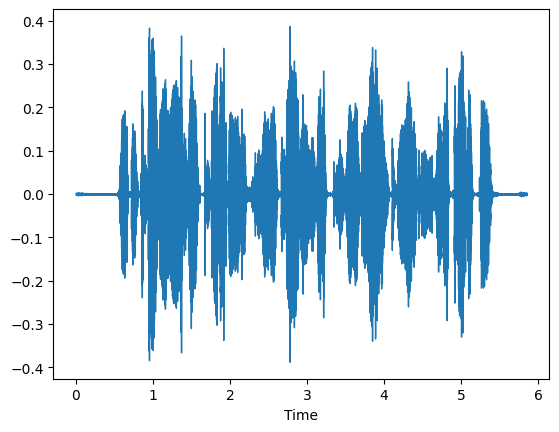

In [93]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

array = sample_array
sr = dataset[0]['audio']['sampling_rate']

plt.figure(12)
librosa.display.waveshow(array, sr=sr)

#Resampling with cast_column

In [94]:
from datasets import Audio

dataset_32k = dataset.cast_column('audio', Audio(sampling_rate = 32000))

dataset_32k.features['audio']

Audio(sampling_rate=32000, decode=True, stream_index=None)

# Filter

In [101]:
!cd ..

In [116]:
MAX_DUR = 10.0

In [126]:
def filter_length(audio_dur):
  return audio_dur < MAX_DUR

dur_col = [librosa.get_duration(y = audio['array'], sr = audio['sampling_rate']) for audio in dataset['audio']]

dataset = dataset.add_column("duration" , dur_col)

In [124]:
dataset.filter(filter_length, input_columns=['duration'])

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id', 'duration'],
    num_rows: 63
})

In [125]:
dataset = dataset.remove_columns(['duration'])

#Feature Extractor

In [127]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

Exception ignored in: <function Wave_write.__del__ at 0x7e269f5b8f40>
Traceback (most recent call last):
  File "/usr/lib/python3.11/wave.py", line 447, in __del__
    self.close()
  File "/usr/lib/python3.11/wave.py", line 565, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.11/wave.py", line 587, in _ensure_header_written
    raise Error('sampling rate not specified')
wave.Error: sampling rate not specified


preprocessor_config.json: 0.00B [00:00, ?B/s]

In [135]:
feature_extractor(sample_array, sampling_rate = 16000, padding = True)

{'input_features': array([[[ 1.19330823e-01, -9.45761204e-02, -1.09778523e-01, ...,
         -3.20934057e-02, -1.17825985e-01, -9.64702368e-02],
        [ 4.93466854e-04, -8.92714262e-02, -6.72897100e-02, ...,
         -1.60930157e-02, -1.21620059e-01, -5.67176342e-02],
        [-1.53263092e-01, -2.08039165e-01, -2.22268224e-01, ...,
         -1.40557170e-01, -2.29890704e-01, -2.50052571e-01],
        ...,
        [-8.06026697e-01, -8.06026697e-01, -7.99966097e-01, ...,
         -6.05042100e-01, -6.05668187e-01, -5.82292438e-01],
        [-8.06026697e-01, -7.72109985e-01, -8.06026697e-01, ...,
         -6.68653011e-01, -6.06035948e-01, -6.81279659e-01],
        [-8.06026697e-01, -8.06026697e-01, -8.06026697e-01, ...,
         -6.53735280e-01, -6.51973128e-01, -7.30241299e-01]]],
      dtype=float32)}

In [138]:
def prep_data(sample):
  audio = sample['audio']
  features = feature_extractor(audio['array'], sampling_rate = audio['sampling_rate'], padding = True)

  return features

In [139]:
dataset = dataset.map(prep_data)

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

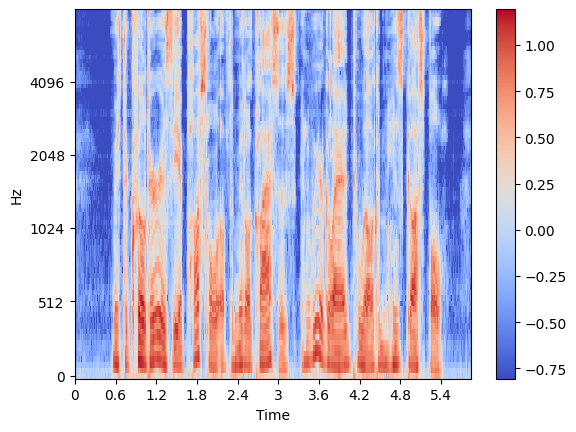

In [143]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


example = dataset[0]

librosa.display.specshow(np.asarray(example['input_features'][0]),
                         sr = feature_extractor.sampling_rate,
                         hop_length = feature_extractor.hop_length,
                         x_axis = 'time',
                         y_axis = 'mel')


plt.colorbar()

#AutoProcessor

In [3]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")